# Part III - Dogs VS Cats 
#####  @ Haim Goldfisher

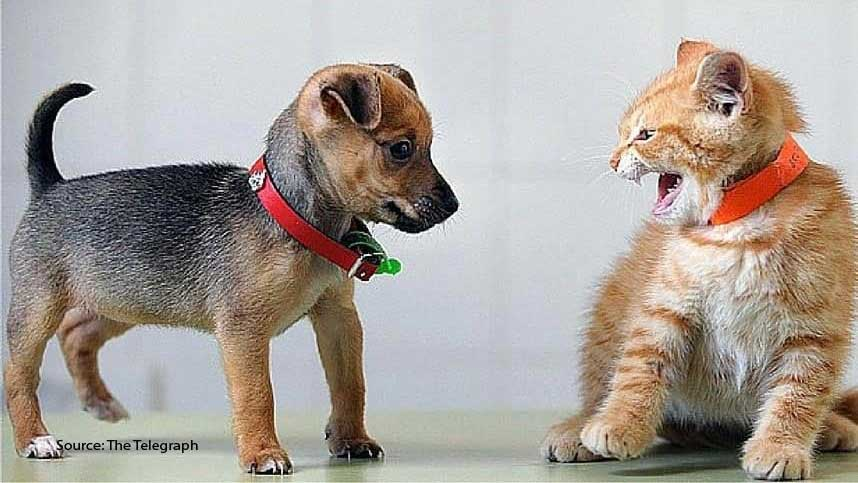

In [1]:
# basic libraries

import glob
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from matplotlib.image import imread
import seaborn as sns

# warnings & offline

import warnings
warnings.filterwarnings('ignore')
import plotly.offline as pyo

# files & pics imports

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from os import listdir
from os.path import isfile, join


# Data Preprocessing & model tools:

from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, roc_auc_score, accuracy_score

# Models:

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

# A model that I learned by myself: CatBoost + Plotly

from catboost import CatBoostClassifier
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

# Clustering:

from sklearn.cluster import KMeans

# PCA:

from sklearn.decomposition import PCA

# Scaling:

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Cross Validation:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# OpenCv & keras image preprocessing
    
import cv2
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

##### Link to kaggle: https://www.kaggle.com/c/dogs-vs-cats

##### We would like to create an array which will contain our images:

##### Because the test folder has no labels, I created a test folder by myself by taking 1000 images of each type and putting them in a folder named 'test'.

In [2]:
main = "C:\Haim\Anaconda\Dogs_VS_Cats"
train = "train"
train = os.path.join(main,train)

test = "test"
test = os.path.join(main,test)

IMAGE_FOLDER_PATH="C:\Haim\Anaconda\Dogs_VS_Cats/train"
FILE_NAMES=os.listdir(IMAGE_FOLDER_PATH)

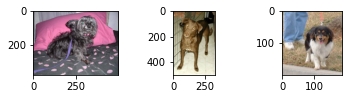

In [3]:
# here's an example of dogs pictures:
for i in range(3):
    plt.subplot(331+i)
    filename=train+'/dog.'+str(i)+'.jpg'
    image=imread(filename)
    plt.imshow(image)
plt.show()  

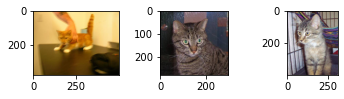

In [4]:
# here's an example of cats pictures:
for i in range(3):
    plt.subplot(331+i)
    filename = train+'/cat.'+str(i)+'.jpg'
    image = imread(filename)
    plt.imshow(image)
plt.show()   

We would like to make a pandas dataframe so we will be able to work with the data of each picture of our train folder

In [5]:
# create dataset
targets=list() # vector of the correct labels (dog or cat), our Y
data = np.ndarray((23000,6075), dtype=np.uint8) # 23000 images , 45^2*45^2 = 2025*3 pixels, our X size
for i, file_name in enumerate(FILE_NAMES): # each file name in our train folder 
    target = file_name.split(".")[0] # the name of each picture starts with dog or cat
    full_path = os.path.join(IMAGE_FOLDER_PATH, file_name) # folder path + the name of the picture
    img = cv2.imread(full_path) # read the photo into matrix of pixels (3D)
    resized_img = cv2.resize(img, (45,45)) # resize each picture into 64*64 pixels
    targets.append(target) # add the correct label of the picture (dog/cat)
    data[i, :] = resized_img.flatten() # add the matrix as a row vector into the correct row in our data array

##### Some important details before uploading the datasets:

* After a lot of trials and errors, this is the best option of dataset that I can think about. I tried to use gray scale's data set but the color has great impact on the model's performents, so I gave up on the idea of gray pictures. In this case, each pixel in each picture has RGB values (3), which multiply the amount of pixels by three. However, after dimensionality reduction by PCA, the number of features we take is much more lower.


* Due to https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/ we would like to create more data by flip our pictures. I wanted to understand the logic of Deep Learning methods which can bring 97% success so I find this article. I have to add that I tried a lot of options of rotatitons and transforms, but 'flip' provides the best results.

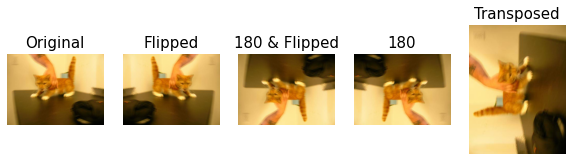

In [6]:
# here's an example of cat pictures with a variety of simple manipulations:

filename = train+'/cat.'+str(0)+'.jpg'
image = imread(filename)
image_flip = cv2.flip(image, 1)
image90 = cv2.flip(image, cv2.ROTATE_90_CLOCKWISE)
image180 = cv2.rotate(image, 1)
image_trans = cv2.transpose(image)

fig, axes = plt.subplots(1,5, figsize = (10,10))
axes = axes.ravel()
axes[0].imshow(image, cmap=plt.get_cmap('gray'))
axes[0].axis('off')
axes[0].set_title("Original", size=15)
axes[1].imshow(image_flip, cmap=plt.get_cmap('gray'))
axes[1].axis('off')
axes[1].set_title("Flipped", size=15)
axes[2].imshow(image90, cmap=plt.get_cmap('gray'))
axes[2].axis('off')
axes[2].set_title("180 & Flipped", size=15)
axes[3].imshow(image180, cmap=plt.get_cmap('gray'))
axes[3].axis('off')
axes[3].set_title("180", size=15)
axes[4].imshow(image_trans, cmap=plt.get_cmap('gray'))
axes[4].axis('off')
axes[4].set_title("Transposed", size=15)

plt.show()


In [7]:
# create dataset for flipped pictures
data_f = np.ndarray((23000,6075), dtype=np.uint8) # 23000 images , 45^2*45^2 = 2025*3 pixels, our X size
for i, file_name in enumerate(FILE_NAMES): # each file name in our train folder 
    full_path = os.path.join(IMAGE_FOLDER_PATH, file_name) # folder path + the name of the picture
    img = cv2.imread(full_path) # read the photo into matrix of pixels (3D)
    img = cv2.flip(img, 1)
    resized_img = cv2.resize(img, (45,45)) # resize each picture into 64*64 pixels
    data_f[i, :] = resized_img.flatten() # add the matrix as a row vector into the correct row in our data array

In [8]:
# we will convert out data array into pandas dataframe, each row present a picture, each column presents a spesific pixel
data = pd.DataFrame(data, columns= ["pixel"+ str(i+1)for i in range(data.shape[1])])
data_f = pd.DataFrame(data_f, columns= ["pixel"+ str(i+1)for i in range(data_f.shape[1])])
data = pd.concat([data, data_f], axis=0)

data.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel6066,pixel6067,pixel6068,pixel6069,pixel6070,pixel6071,pixel6072,pixel6073,pixel6074,pixel6075
0,93,170,209,99,177,220,106,184,227,113,...,4,1,2,2,1,2,2,1,2,2
1,41,42,38,63,58,55,36,36,30,48,...,75,44,52,69,49,53,71,25,31,44
2,52,44,37,58,48,41,64,54,47,67,...,166,59,147,153,0,180,182,10,187,189
3,217,222,221,222,227,226,234,232,232,225,...,203,203,205,205,221,222,220,207,212,215
4,70,107,135,60,97,125,42,81,108,73,...,97,67,90,105,62,93,104,65,89,101


In [9]:
# we will convert out targets list into a pandas df so we will add it to the data df
labels = pd.DataFrame({"label":targets})
labels = pd.concat([labels, labels], axis=0) # double the size of labels
labels.sample(n = 4, random_state = 4).sort_values(by = 'label')

,label
7782,cat
1560,cat
18868,dog
19503,dog


In [10]:
df = pd.concat([labels, data], axis=1) # our full data frame of train
df.reset_index(drop=True, inplace=True)
df.sample(n = 4, random_state = 4).sort_values(by = 'label')

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel6066,pixel6067,pixel6068,pixel6069,pixel6070,pixel6071,pixel6072,pixel6073,pixel6074,pixel6075
7782,cat,108,102,64,105,102,63,110,104,67,...,101,116,202,152,105,169,127,79,83,82
24560,cat,119,140,167,125,146,173,126,150,176,...,15,18,20,20,28,28,28,23,23,23
18868,dog,111,112,126,104,105,118,99,94,103,...,107,119,117,130,132,140,158,115,120,137
42503,dog,48,88,64,141,166,164,61,74,71,...,75,74,81,98,46,54,66,77,86,100


In [11]:
df.shape # 23000 pics + 23000 flipped pics, 6075 pixels and 1 label column

(46000, 6076)

#### Since we don't have labels for the test1 folder, I took 1000 images of each type and transferred them to a test folder. We would like to load this folder

In [12]:
# now we will create a df for out test

IMAGE_FOLDER_PATH="C:\Haim\Anaconda\Dogs_VS_Cats/test"
FILE_NAMES=os.listdir(IMAGE_FOLDER_PATH)

# create dataset
y_test = list() # vector of the correct labels (dog or cat)
data_test = np.ndarray((2000,6075), dtype=np.uint8) # 2000 , 45^2*45^2 = 2025*3 pixels, our X size
for i, file_name in enumerate(FILE_NAMES): # each file name in our train folder 
    target = file_name.split(".")[0] # the name of each picture starts with dog or cat
    full_path = os.path.join(IMAGE_FOLDER_PATH, file_name) # folder path + the name of the picture
    img = cv2.imread(full_path) # read the photo into matrix of pixels (3D)
    resized_img = cv2.resize(img, (45,45)) # resize each picture into 64*64 pixels
    y_test.append(target) # add the correct label of the picture (dog/cat)
    data_test[i, :] = resized_img.flatten() # add the matrix as a row vector into the correct row in our data array

# since we are not allowed to touch the test, there is no reason to connect the data with the labels    
    
y_test = pd.DataFrame({"label":y_test})    
X_test = pd.DataFrame(data_test, columns= ["pixel"+ str(i+1)for i in range(data.shape[1])])
X_test.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel6066,pixel6067,pixel6068,pixel6069,pixel6070,pixel6071,pixel6072,pixel6073,pixel6074,pixel6075
0,204,199,198,204,199,198,208,200,200,229,...,144,89,91,92,60,68,42,49,52,30
1,151,156,145,126,124,157,35,44,61,128,...,89,87,72,84,75,59,70,83,66,79
2,163,175,181,160,172,178,161,173,179,166,...,146,113,129,146,109,124,140,105,120,136
3,69,77,90,48,61,78,63,80,83,112,...,116,47,53,52,20,21,19,58,64,62
4,97,91,56,102,101,61,86,92,74,84,...,171,107,117,179,107,112,174,112,114,179


##### After we have finished uploading all our data and converting it to CSV files, we would like to see how the images are really displayed through the rows in our data frame

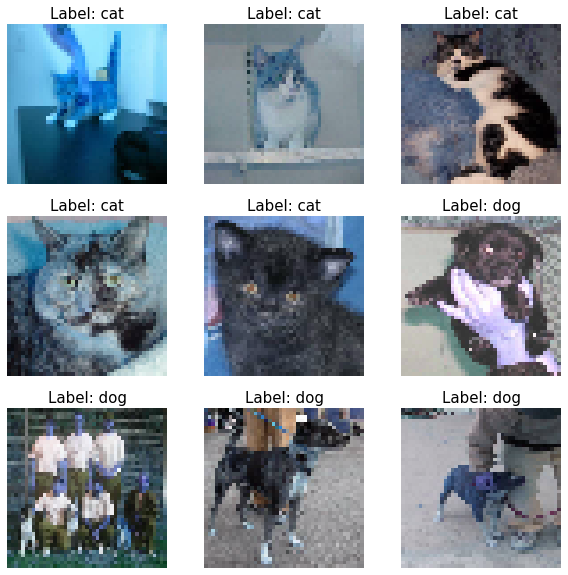

In [14]:
fig, axes = plt.subplots(3, 3, figsize = (10,10))
axes = axes.ravel()

for i in range(9):
    axes[i].imshow(data.values.reshape((data.shape[0], 45, 45, 3))[i*2550])
    axes[i].set_title("Label: " + str(df.label[i*2550]), size=15)
    axes[i].axis('off')
plt.show()

##### Some cv2 methods which I tried to use In order to optimize the model, but nothing of them succeeded:

##### I thought that maybe if I emphasize the outline in the picture of the animal, it will make it easier for the model to distinguish between a dog and a cat. But it turns out that I need a little more knowledge than I have in order to do this effectively. I gave you the opportunity to see the cool but not particularly effective results I got

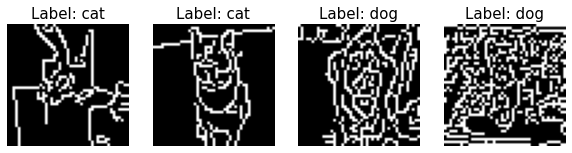

In [15]:
# Canny method

fig, axes = plt.subplots(1, 4, figsize = (10,10))
axes = axes.ravel()

for i in range(4):
    img = data.values.reshape((data.shape[0], 45, 45, 3))[i*7500];
    edges = cv2.Canny(img, threshold1 = 100, threshold2 = 200)
    img = cv2.cvtColor(edges, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img, cmap=plt.get_cmap('gray'))
    axes[i].set_title("Label: " + df.label[i*7500], size=15)
    axes[i].axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


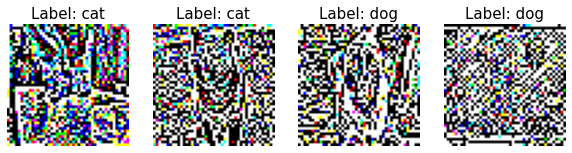

In [16]:
# Laplacian method

fig, axes = plt.subplots(1, 4, figsize = (10,10))
axes = axes.ravel()

for i in range(4):
    img = data.values.reshape((data.shape[0], 45, 45, 3))[i*7500];
    laplacian = cv2.Laplacian(img, cv2.CV_64F)
    img = cv2.cvtColor(laplacian.astype('float32'), cv2.COLOR_RGB2BGR)
    axes[i].imshow(img, cmap=plt.get_cmap('gray'))
    axes[i].set_title("Label: " + df.label[i*7500], size=15)
    axes[i].axis('off')
plt.show();

##### Let's continue to deal with the data:

In [17]:
# simple mapping of the labels into numbers

mapping = {'cat':0, 'dog':1}
df.label = df.label.map(mapping)
y_test = y_test.label.map(mapping)
df.sample(2, random_state=555)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel6066,pixel6067,pixel6068,pixel6069,pixel6070,pixel6071,pixel6072,pixel6073,pixel6074,pixel6075
24181,0,0,20,98,0,21,99,1,35,126,...,83,38,64,80,36,59,74,34,64,75
36919,1,58,73,79,76,83,92,92,99,109,...,110,101,98,90,111,104,109,101,100,100


In [18]:
# A function to show the labels when we it needed

def num_to_name(label):
    labeled = label.copy()
    mapping = {0 :'Cat',
    1 :'Dog'}
    labeled = label.map(mapping)
    return labeled

In [19]:
df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel6066,pixel6067,pixel6068,pixel6069,pixel6070,pixel6071,pixel6072,pixel6073,pixel6074,pixel6075
count,46000.000000,46000.000000,46000.000000,46000.000000,46000.000000,46000.000000,46000.000000,46000.000000,46000.000000,46000.000000,...,46000.000000,46000.000000,46000.000000,46000.00000,46000.000000,46000.000000,46000.000000,46000.000000,46000.000000,46000.000000
mean,0.500000,105.776957,113.879652,118.374109,106.321674,114.559326,119.161630,106.896152,115.332370,120.020174,...,128.976739,112.653565,121.137543,127.71387,111.666000,120.017870,126.457500,110.787630,118.997478,125.240674
std,0.500005,72.222756,70.735095,71.035327,71.973537,70.451306,70.791182,71.616338,70.082139,70.439963,...,67.978541,68.627585,66.727919,68.20896,68.787798,66.953883,68.465039,69.151159,67.333191,68.774698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,45.000000,54.000000,59.000000,45.000000,55.000000,60.000000,46.000000,56.000000,62.000000,...,75.000000,56.000000,68.000000,74.00000,55.000000,67.000000,72.000000,54.000000,65.000000,70.000000
50%,0.500000,95.000000,108.000000,114.000000,96.000000,109.000000,115.000000,97.000000,111.000000,117.000000,...,129.000000,107.000000,120.000000,128.00000,106.000000,118.000000,126.000000,104.000000,117.000000,124.000000
75%,1.000000,158.000000,166.000000,172.000000,158.000000,167.000000,173.000000,159.000000,167.000000,174.000000,...,181.000000,163.000000,170.000000,179.00000,161.000000,169.000000,178.000000,160.000000,168.000000,177.000000
max,1.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.00000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [20]:
df[df['label']==0].describe() # for cats

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel6066,pixel6067,pixel6068,pixel6069,pixel6070,pixel6071,pixel6072,pixel6073,pixel6074,pixel6075
count,23000.0,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,...,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000
mean,0.0,103.017130,109.829348,116.110043,103.701739,110.649261,117.074304,104.445609,111.618130,118.138043,...,129.806217,113.948261,119.475826,128.096739,112.513435,117.864174,126.306783,111.357391,116.553913,124.790652
std,0.0,72.297679,71.143112,71.452112,72.251220,71.033367,71.415441,71.930307,70.684899,71.076800,...,70.888013,71.223152,69.846556,71.128635,71.350114,70.052935,71.406110,71.561842,70.165558,71.444007
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,41.000000,49.000000,55.000000,42.000000,50.000000,56.000000,43.000000,52.000000,58.000000,...,72.000000,53.000000,61.000000,70.000000,52.000000,59.000000,67.000000,50.750000,58.000000,65.000000
50%,0.0,92.000000,103.000000,112.000000,93.000000,104.000000,113.000000,95.000000,106.000000,115.000000,...,132.000000,109.000000,118.000000,130.000000,107.000000,115.000000,127.000000,105.000000,113.000000,125.000000
75%,0.0,155.000000,162.000000,170.000000,156.000000,163.000000,171.000000,157.000000,165.000000,172.000000,...,186.000000,168.000000,172.000000,184.000000,166.000000,171.000000,182.000000,165.000000,169.000000,180.000000
max,0.0,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [21]:
df[df['label']==1].describe() # for dogs

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel6066,pixel6067,pixel6068,pixel6069,pixel6070,pixel6071,pixel6072,pixel6073,pixel6074,pixel6075
count,23000.0,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,...,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000,23000.000000
mean,1.0,108.536783,117.929957,120.638174,108.941609,118.469391,121.248957,109.346696,119.046609,121.902304,...,128.147261,111.358870,122.799261,127.331000,110.818565,122.171565,126.608217,110.217870,121.441043,125.690696
std,0.0,72.043677,70.092589,70.545007,71.600543,69.646759,70.100795,71.218275,69.276826,69.748088,...,64.929797,65.906036,63.414192,65.157891,66.116965,63.632924,65.393035,66.650033,64.285039,65.996005
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,48.000000,60.000000,63.000000,49.000000,61.000000,64.000000,50.000000,62.000000,65.000000,...,78.000000,58.000000,74.750000,77.000000,58.000000,73.000000,76.000000,57.000000,73.000000,75.000000
50%,1.0,99.000000,114.000000,117.000000,99.000000,115.000000,118.000000,100.000000,116.000000,119.000000,...,127.000000,105.000000,121.000000,126.000000,104.000000,120.000000,125.000000,103.000000,119.000000,124.000000
75%,1.0,160.000000,170.000000,174.000000,160.000000,170.000000,174.000000,161.000000,170.000000,175.000000,...,175.000000,157.000000,167.000000,174.000000,157.000000,167.000000,174.000000,156.000000,166.000000,174.000000
max,1.0,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [22]:
df.isnull().sum().sum() # the dataset has no NaN values

0

In [23]:
target = df['label'] # the feature we would like to predict, the label of picture
data = df.drop(['label'], axis = 1) # we will drop y from x, because we want to predict it

In [24]:
num_to_name(target).value_counts() # count the examples we have in each lable

Cat    23000
Dog    23000
Name: label, dtype: int64

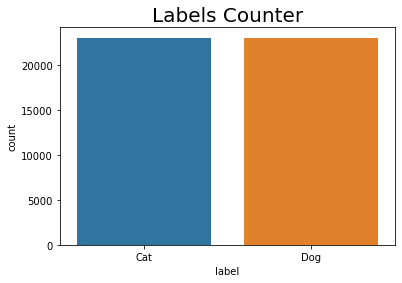

In [25]:
# a simple counter graph

plt.subplots(figsize = (6,4))
plt.title("Labels Counter", size=20)
fig = sns.countplot(num_to_name(target))

##### Our data is divided equally. So a dummy classifier model will give us 50 percent success.

## Data Processing

### Training / Testing Split:

##### Since most of the images are different from each other, some in a minor way and some in a very significant way, I estimate that we need to use as much data as possible in order to be successful in the classification process. It is I prefer to take 0.15 percent of the data for the test. We will also do cross validation so I guess we will not run into overfitting issues anyway. 

##### Another assessment I have, and it is perhaps most important of all, is that although we doubled the amount of data by 2 by adding mirror images, our model could not learn from one image to its mirror image. Therefore, I estimate that even though I took a small test and multiplied my data with supposedly the "same" data, there will be no overfitting problem here.

In [26]:
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.15, random_state=18)

### Scaling:

In [27]:
# from 64 to 32: to avoid infinity cases with high numbers

X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

##### Since we have 256 pixels (0-255), we can divide them into 255 in order to achieve the desired range values (0-1).

In [28]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

# Dimensionality Reduction: PCA

##### Some important things to talk about before we get started. Unlike the previous notebook, this time it would not be right to use ICA. As we saw at the beginning of the notebook, the animals in each picture are in a different place. It is not possible here to select a few important pixels but to identify the animal in each image. Plus, since I want to get good results, I'm willing to accept a large amount of features. We will go for as standard a dimension reduction as possible (apparently n_components = 0.95). That means even if we are left with a relatively high amount of features it is fine

##### We would like to find out optimal n_components value

In [29]:
pca = PCA() # all 6075 features
pca.fit(X_train)

PCA()

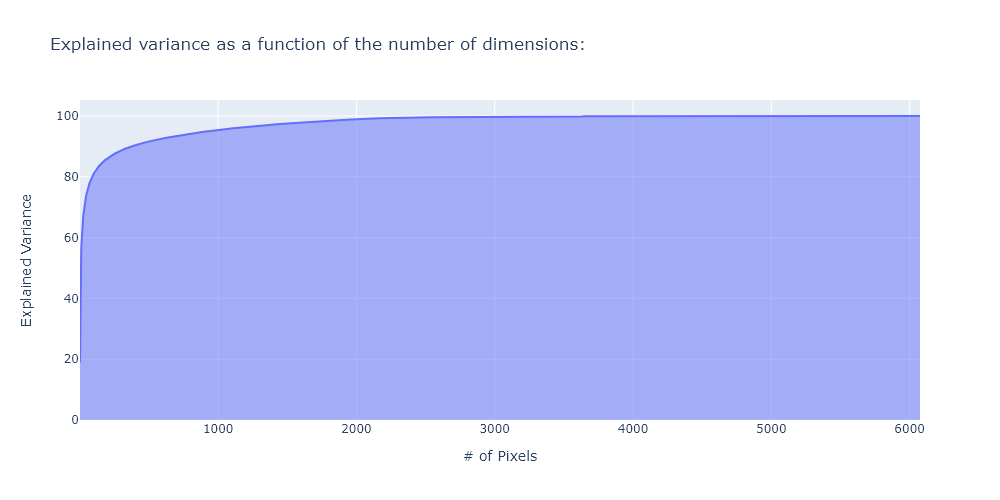

In [30]:
# Explained variance graph

exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

fig = px.area(
    title = "Explained variance as a function of the number of dimensions:",
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul * 100,
    labels={"x": "# of Pixels", "y": "Explained Variance"},
    width = 1000 ,
    height = 500
)

fig.show("png")

In [31]:
pca = PCA(n_components=0.95) # we can also try using svd_solver="randomized"
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)
pca.n_components_

930

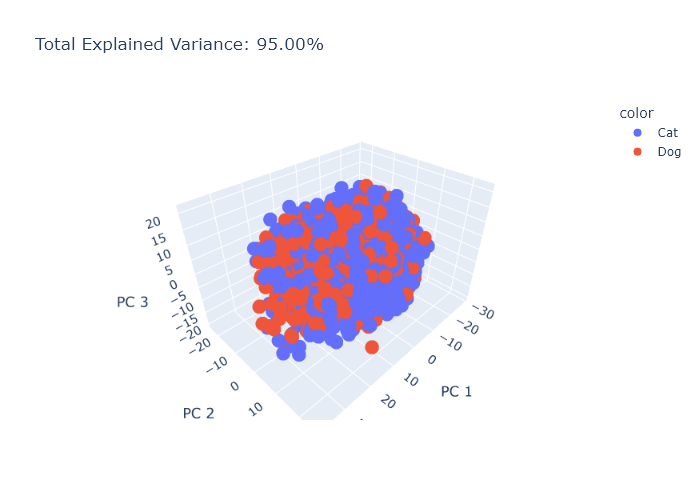

In [32]:
# A three-dimensional graph depicting the way our data is interpreted, plotly does it easily for us 
total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter_3d(
    X_train_reduced, x=0, y=1, z=2, color = num_to_name(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show("png")

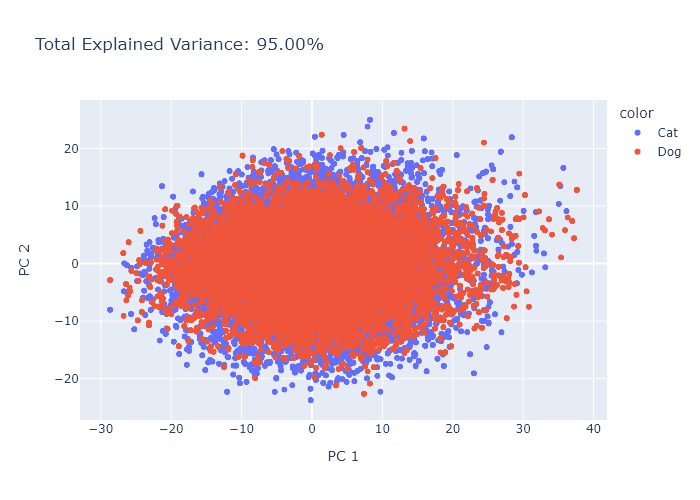

In [33]:
# 2D version: with x and y
total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter(
    X_train_reduced, x=0, y=1, color = num_to_name(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show("png")

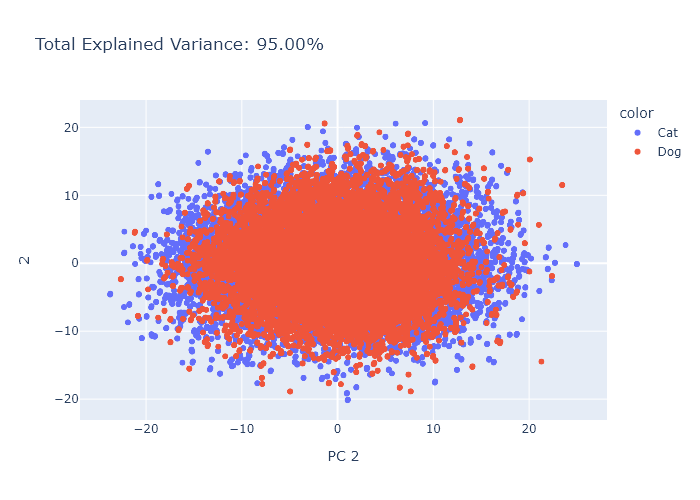

In [34]:
# 2D version: with y and z
total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter(
    X_train_reduced, x=1, y=2, color = num_to_name(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show("png")


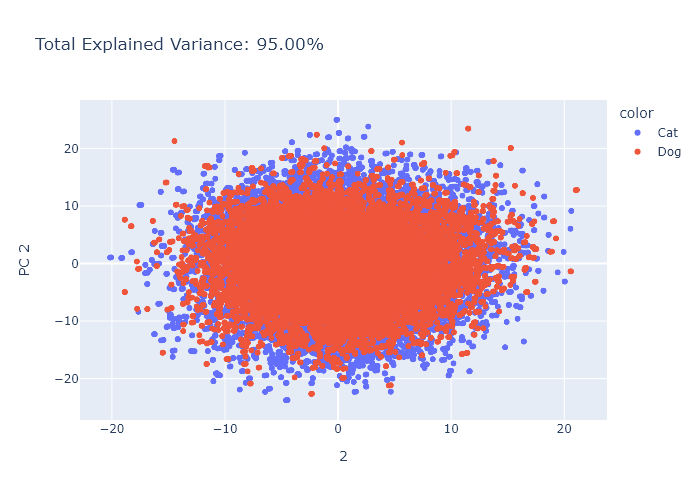

In [35]:
# 2D version: with z and y
total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter(
    X_train_reduced, x=2, y=1, color = num_to_name(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show("png")

##### After reducing the num of the features, we will convert X_train & X_validation to pandas data frames:

In [36]:
X_train = pd.DataFrame(X_train_reduced)
X_val = pd.DataFrame(X_val_reduced)

# Models

## Naive Bayes

In [37]:
bayes = GaussianNB()
bayes.fit(X_train, y_train)
bayes

GaussianNB()

In [38]:
y_pred = bayes.predict(X_val)
bayes_acc = accuracy_score(y_val, y_pred)
bayes_acc

0.5842028985507246

In [39]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.69      0.63      3453
           1       0.61      0.47      0.53      3447

    accuracy                           0.58      6900
   macro avg       0.59      0.58      0.58      6900
weighted avg       0.59      0.58      0.58      6900



## KNN

In [40]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn

KNeighborsClassifier()

In [41]:
y_pred = knn.predict(X_val)
knn_acc = accuracy_score(y_val, y_pred)
knn_acc

0.5957971014492753

In [42]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.74      0.65      3453
           1       0.63      0.46      0.53      3447

    accuracy                           0.60      6900
   macro avg       0.60      0.60      0.59      6900
weighted avg       0.60      0.60      0.59      6900



## Logistic Regression

In [43]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr

LogisticRegression()

In [44]:
y_pred = lr.predict(X_val)
lr_acc = accuracy_score(y_val, y_pred)
lr_acc

0.61

In [45]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.62      0.62      3453
           1       0.61      0.60      0.60      3447

    accuracy                           0.61      6900
   macro avg       0.61      0.61      0.61      6900
weighted avg       0.61      0.61      0.61      6900



## CatBoost

In [46]:
cat = CatBoostClassifier(logging_level='Silent')
cat.fit(X_train, y_train)
cat

In [47]:
y_pred = cat.predict(X_val)
y_pred_cat = y_pred.copy()
cat_acc = accuracy_score(y_val, y_pred)
cat_acc

0.7220289855072464

In [48]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72      3453
           1       0.73      0.71      0.72      3447

    accuracy                           0.72      6900
   macro avg       0.72      0.72      0.72      6900
weighted avg       0.72      0.72      0.72      6900



## AdaBoost

In [49]:
#rfc = RandomForestClassifier(n_estimators=10)
#ada = AdaBoostClassifier(n_estimators=100,learning_rate= 0.1, base_estimator=rfc)
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
ada

AdaBoostClassifier()

In [50]:
y_pred = ada.predict(X_val)
ada_acc = accuracy_score(y_val, y_pred)
ada_acc

0.628695652173913

In [51]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.64      0.63      3453
           1       0.63      0.62      0.62      3447

    accuracy                           0.63      6900
   macro avg       0.63      0.63      0.63      6900
weighted avg       0.63      0.63      0.63      6900



## Gradient Boosting

In [52]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb

GradientBoostingClassifier()

In [53]:
y_pred = gb.predict(X_val)
gb_acc = accuracy_score(y_val, y_pred)
gb_acc

0.6660869565217391

In [54]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67      3453
           1       0.67      0.65      0.66      3447

    accuracy                           0.67      6900
   macro avg       0.67      0.67      0.67      6900
weighted avg       0.67      0.67      0.67      6900



### XGBoost

In [55]:
xgb = XGBClassifier(use_label_encoder =False)
xgb.fit(X_train, y_train)
xgb

[12:29:46] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [56]:
y_pred = xgb.predict(X_val)
xgb_acc = accuracy_score(y_val, y_pred)
xgb_acc

0.6866666666666666

In [57]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.69      0.69      3453
           1       0.69      0.68      0.69      3447

    accuracy                           0.69      6900
   macro avg       0.69      0.69      0.69      6900
weighted avg       0.69      0.69      0.69      6900



### Random Forest

In [58]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf

RandomForestClassifier()

In [59]:
y_pred = rf.predict(X_val)
rf_acc = accuracy_score(y_val, y_pred)
rf_acc

0.6128985507246377

In [60]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.59      0.60      3453
           1       0.61      0.64      0.62      3447

    accuracy                           0.61      6900
   macro avg       0.61      0.61      0.61      6900
weighted avg       0.61      0.61      0.61      6900



### Stacking

In [61]:
stacking = StackingClassifier(estimators=[('gxb',xgb),('rf',rf)],final_estimator=cat)
stacking.fit(X_train,y_train)
stacking

[12:37:18] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:44:45] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:48:32] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:20] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

StackingClassifier(estimators=[('gxb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.300000012,
                                              max_delta_step=0, max_depth=6,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=100, n_jobs=8,
                                              num_parallel_tree=1,
                                              random_state=0, reg_alpha=0,


In [62]:
y_pred = stacking.predict(X_val)
stacking_acc = accuracy_score(y_val, y_pred)
stacking_acc

0.6876811594202898

In [63]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69      3453
           1       0.69      0.68      0.68      3447

    accuracy                           0.69      6900
   macro avg       0.69      0.69      0.69      6900
weighted avg       0.69      0.69      0.69      6900



### Soft Voting

In [64]:
clf1 = xgb
clf2 = cat
clf3 = rf

In [65]:
sv = VotingClassifier(estimators=[
        ('xgb', clf1), ('cat', clf2)], voting='soft') # , ('rf', clf3)
sv.fit(X_train, y_train)
sv

[13:14:11] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=6,
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=8,
                                            num_parallel_tree=1, random_state=0,
                                            reg_alpha=0, reg_lambda=1,
              

In [66]:
y_pred = sv.predict(X_val)
sv_acc = accuracy_score(y_val, y_pred)
sv_acc

0.7157971014492753

In [67]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.72      0.72      3453
           1       0.72      0.71      0.71      3447

    accuracy                           0.72      6900
   macro avg       0.72      0.72      0.72      6900
weighted avg       0.72      0.72      0.72      6900



##### We can see that voting model didn't improve our model. It can be explained by the fact that xgb and catboost are both gradinet boosting alogrithms. In that case, their strategy is a little bit the same. In this case, catboost did better job, so we don't need xgb.

In [68]:
acc_list = {'Model':  ['Naive Bayes', 'KNN','Logistic Regression','CatBoost', 'AdaBoost', 'Gradient Boosting', 'XGBoost','Random Forest','Stacking', 'Soft Voting'],
        'Accuracy': [bayes_acc,knn_acc,lr_acc,cat_acc,ada_acc,gb_acc,xgb_acc,rf_acc,stacking_acc,sv_acc],
        }

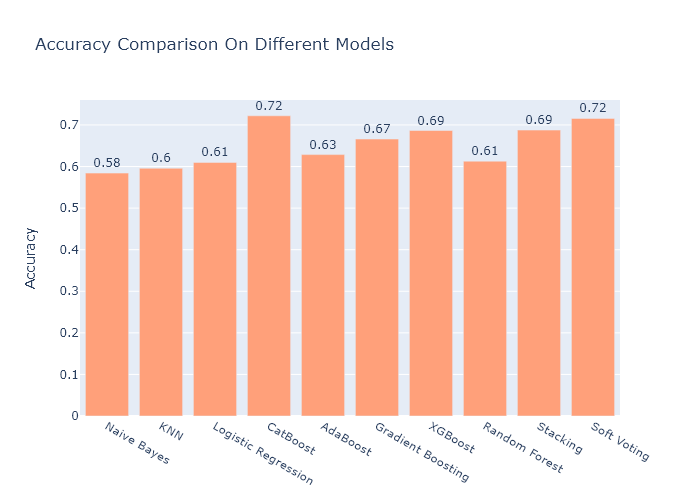

In [69]:
# bar graph as a conclusion to the models
fig = go.Figure(data=[
    go.Bar(name='train set', x=acc_list['Model'], y=acc_list['Accuracy'],text=np.round(acc_list['Accuracy'],2),textposition='outside',marker_color='lightsalmon'),
])
fig.update_layout(barmode='group',title_text='Accuracy Comparison On Different Models',yaxis=dict(
        title='Accuracy'))
fig.show("png")

As we can see, CatBoost has the best results with 72.2 % of success

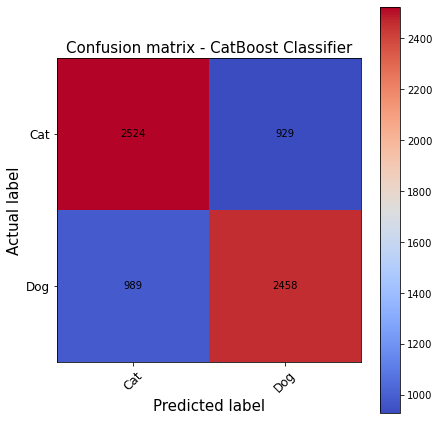

In [70]:
# we would like to present confusion matrix for our best model:

cm = confusion_matrix(y_val, y_pred_cat)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap = plt.cm.coolwarm)
plt.title('Confusion matrix - CatBoost Classifier', size = 15)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Cat','Dog'], rotation=45, size = 12)
plt.yticks(tick_marks, ['Cat','Dog'], size = 12)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
        horizontalalignment='center',
        verticalalignment='center')

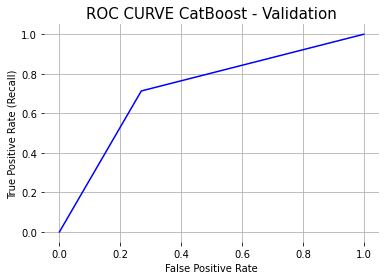

The score for the ROC Curve is: 72.2%


In [71]:
# ROC curve for our best model at validation:

fpr, tpr, _= roc_curve(y_val, y_pred_cat)
auc= roc_auc_score(y_val, y_pred_cat)
plt.plot(fpr, tpr, label="auc="+str(auc), color='blue')
plt.box(False)
plt.title('ROC CURVE CatBoost - Validation', size=15)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid(True)
plt.show()

dct_auc = round(auc,3)*100
 
print(f"The score for the ROC Curve is: {round(auc,3)*100}%")

## Cross Validation by Pipeline & Grid Search

In [72]:
# we will concat our X,y train & validation for cross validation for our best model - catboost

X = pd.concat([X_train, X_val], axis = 0)
y = pd.concat([y_train, y_val], axis = 0)

# now the dataset is united again, we can split it 5 time for cv score

pipe = Pipeline(steps=[('CatBoost', cat)])
search = GridSearchCV(pipe, param_grid={'CatBoost__iterations':[100,250,500]}, cv=5) # 5 cv on iterations
search.fit(X, y) # we will apply cv on our whole data because we would like our model to see more examples
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.712):
{'CatBoost__iterations': 500}


##### The beautiful results we got by the cross validation show that even though we doubled the amount of images, the model remained balanced. Turns out the idea to flipping the photos was successful.

# Test

In [73]:
X_test = pca.transform(X_test)
y_pred = search.predict(X_test)

In [74]:
accuracy_score(y_test, y_pred)

0.7015

In [75]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70      1000
           1       0.70      0.71      0.70      1000

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000



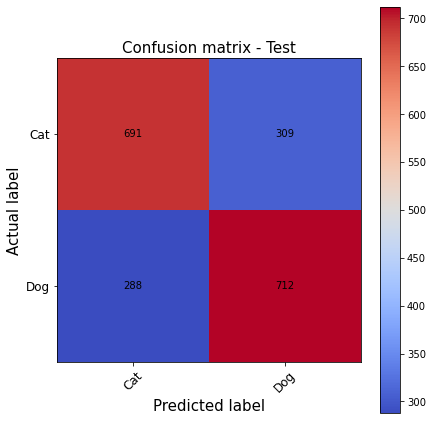

In [76]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap = plt.cm.coolwarm)
plt.title('Confusion matrix - Test', size = 15)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Cat','Dog'], rotation=45, size = 12)
plt.yticks(tick_marks, ['Cat','Dog'], size = 12)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
        horizontalalignment='center',
        verticalalignment='center')

##### It can be seen that our model is relatively balanced. That is, it was able to classify dogs a little better than cats, but the difference is negligible.

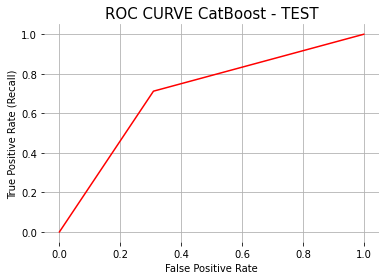

The score for the ROC Curve is: 70.19999999999999%


In [77]:
# ROC curve for our best model at test:

fpr, tpr, _= roc_curve(y_test, y_pred)
auc= roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label="auc="+str(auc), color='red')
plt.box(False)
plt.title('ROC CURVE CatBoost - TEST', size=15)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid(True)
plt.show()

dct_auc = round(auc,3)*100
 
print(f"The score for the ROC Curve is: {round(auc,3)*100}%")

# To sum up, our CatBoost model had 70.15% of success on the Test data. It did it by using 930 of 6075 features.